In [1]:
import warnings
warnings.simplefilter(action='ignore')
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import signal
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
df_data = pd.read_csv('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/Part 3/Part1 Data.csv')
df_trends_raw = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/Part 3/US_WI_55079.xlsx')
df_columns = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/Part 3/trends_columns.xlsx')
df_vaccine = pd.read_excel('/content/drive/MyDrive/MS Admission/Washington/Human Centered Design/Project/Part 3/Vaccination Search Insights.xlsx')

In [3]:
cols = list(df_columns['column'])
df_trends = df_trends_raw[df_trends_raw.columns.intersection(cols)]
df_trends = df_trends[(df_trends['date'] >= '2020-02-01') & (df_trends['date'] <= '2021-10-01')]
df_trends.head()

,date,country_code,subregion1_name,subregion2_name,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,...,search_trends_visual_acuity,search_trends_vomiting,search_trends_wart,search_trends_water_retention,search_trends_weakness,search_trends_weight_gain,search_trends_wheeze,search_trends_xeroderma,search_trends_xerostomia,search_trends_yawn
31,2020-02-01,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.15,3.08,1.09,0.23,0.36,3.02,0.23,2.33,0.32,0.16
32,2020-02-02,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,3.42,1.23,0.26,0.36,3.35,0.27,2.32,0.30,0.21
33,2020-02-03,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.18,2.99,1.13,0.22,0.34,3.27,0.30,1.96,0.33,0.14
34,2020-02-04,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.24,2.63,1.22,0.26,0.46,3.11,0.25,1.89,0.41,0.20
35,2020-02-05,US,Wisconsin,Milwaukee County,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,3.02,1.10,0.31,0.37,3.05,0.26,2.14,0.37,0.16


In [4]:
print(df_data.shape, df_trends.shape, df_vaccine.shape)

(609, 18) (609, 425) (88, 5)


In [5]:
df_data['date'] = pd.to_datetime(df_data['date'])
df_main =  df_trends.merge(df_data, how='inner', on='date')
df_main = df_main.merge(df_vaccine, how = 'left', on = 'date')
df_main['mask_required'] = df_main['mask_required'].replace(np.nan, 'No')
df_main[['new_confirmed',	'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'new_persons_fully_vaccinated',	'cumulative_persons_fully_vaccinated']] = df_main[['new_confirmed',	'new_deceased', 'cumulative_confirmed', 'cumulative_deceased', 'new_persons_fully_vaccinated',	'cumulative_persons_fully_vaccinated']].replace(np.nan, 0)
print(df_main.shape)
df_main.head()

(609, 446)


,date,country_code,subregion1_name,subregion2_name,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,...,infected,susceptible,transmission_rate,infection_rate,r0,derivative,key,sni_covid19_vaccination,sni_vaccination_intent,sni_safety_side_effects
0,2020-02-01,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2020-02-02,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2020-02-03,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2020-02-04,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2020-02-05,US,Wisconsin,Milwaukee County,0.0,0.0,0.0,0.0,0.0,0.0,...,0,945726.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [6]:
df_wave1 = df_main[(df_main['date'] >= '2020-03-01') & (df_main['date'] < '2020-08-01')]
df_wave2 = df_main[(df_main['date'] >= '2020-08-01') & (df_main['date'] <= '2021-03-30')]
df_wave3 = df_main[df_main['date'] >= '2021-03-30']
df_wave1.reset_index(inplace = True)
df_wave2.reset_index(inplace = True)
df_wave3.reset_index(inplace = True)

In [7]:
covid_symptoms = ['search_trends_sore_throat', 'search_trends_chills', 'search_trends_fever', 'search_trends_cough', 'search_trends_sinusitis', 
'search_trends_common_cold', 'search_trends_shortness_of_breath', 'search_trends_shallow_breathing', 'search_trends_fatigue', 'search_trends_muscle_weakness', 
'search_trends_headache', 'search_trends_nasal_congestion', 'search_trends_nausea', 'search_trends_vomiting', 'search_trends_diarrhea', 'search_trends_pneumonia']

covid_symptoms_short = [item.replace('search_trends_', '') for item in covid_symptoms]
covid_symptoms_short = [item.replace('_', ' ') for item in covid_symptoms_short]

df_wave1[covid_symptoms_short] = df_wave1[covid_symptoms]
df_wave1 = df_wave1.drop(covid_symptoms, axis = 1)
df_wave2[covid_symptoms_short] = df_wave2[covid_symptoms]
df_wave2 = df_wave2.drop(covid_symptoms, axis = 1)
df_wave3[covid_symptoms_short] = df_wave3[covid_symptoms]
df_wave3 = df_wave3.drop(covid_symptoms, axis = 1)

### Analyse the correlation between Confirmed cases and COVID symptom search terms

In [12]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

def window_corr(data, column):
  # Rolling window time lagged cross correlation
  window_size = 60 #samples
  t_start = 0
  t_end = t_start + window_size
  step_size = 2
  rss = []
  while t_end < data.shape[0]:
      d1 = data['cases'].iloc[t_start:t_end]
      d2 = data[column].iloc[t_start:t_end]
      rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(0, 22)]
      rss.append(rs)
      t_start = t_start + step_size
      t_end = t_end + step_size
  rss = pd.DataFrame(rss)
  return rss

def plot_corr(data1, data2, data3, column):
  f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 18))
  f.suptitle('Time Lagged Correlation plots before, during and after mask mandate in Milwaukee County')
  sns.heatmap(data1, cmap='RdBu_r',ax=ax1)
  ax1.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) before mask mandate'% column.title(), xlim=[0, 22], xlabel='Lag, days',ylabel='Epochs')
  ax1.set_xticklabels([int(item) for item in ax1.get_xticks()]);
  sns.heatmap(data2, cmap='RdBu_r',ax=ax2)
  ax2.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) during mask mandate'% column.title(), xlim=[0, 22], xlabel='Lag, days',ylabel='Epochs')
  ax2.set_xticklabels([int(item) for item in ax2.get_xticks()]);
  sns.heatmap(data3, cmap='RdBu_r',ax=ax3)
  ax3.set(title = f'Rolling Windowed Time Lagged Cross Correlation (Cases vs. %s Symptom Search) after mask mandate'% column.title(), xlim=[0, 22], xlabel='Lag, days',ylabel='Epochs')
  ax3.set_xticklabels([int(item) for item in ax3.get_xticks()]);

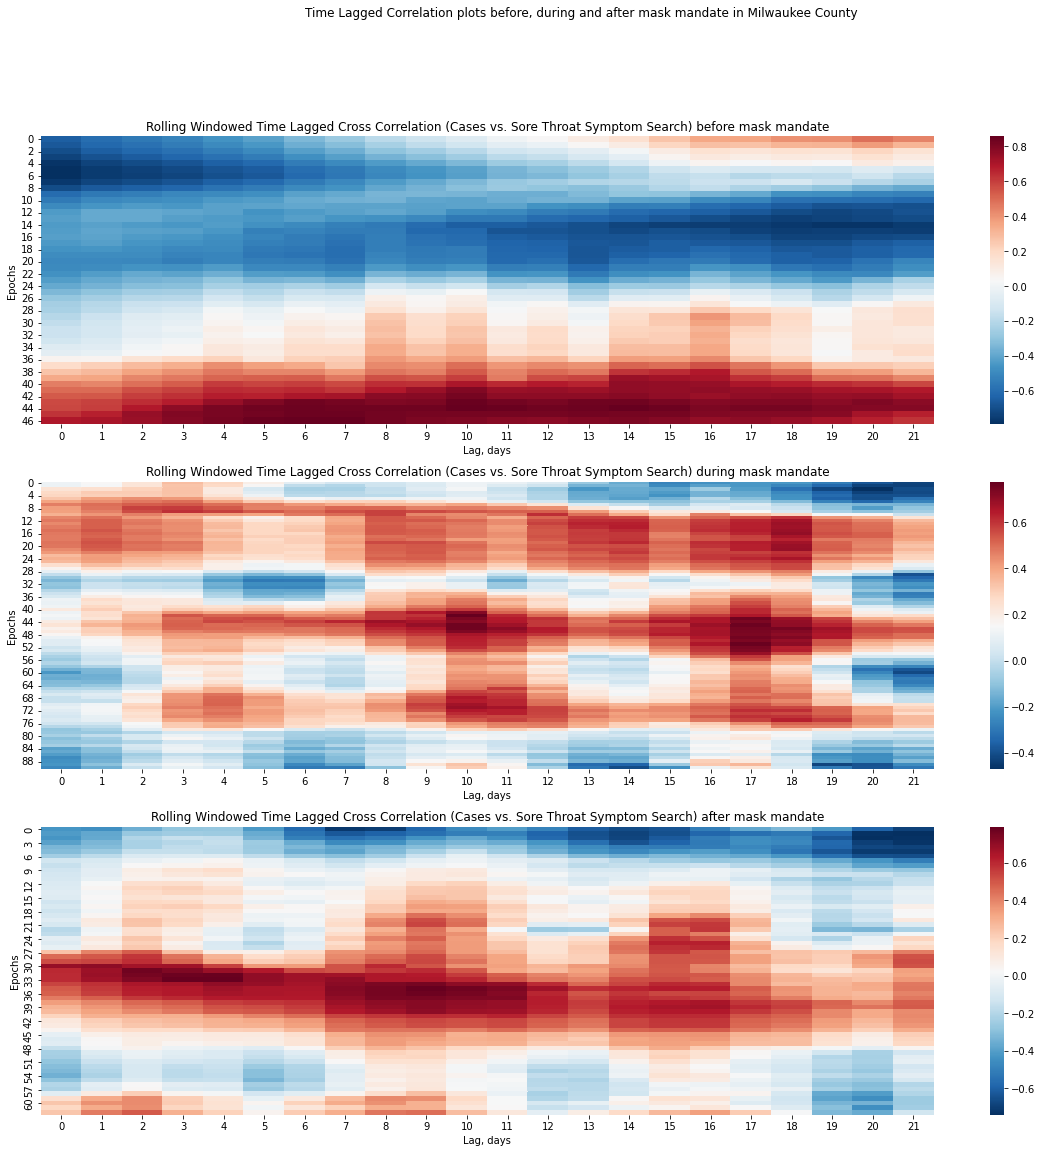

In [13]:
rss1, rss2, rss3 = window_corr(df_wave1, 'sore throat'),window_corr(df_wave2, 'sore throat'), window_corr(df_wave3, 'sore throat')
plot_corr(rss1, rss2, rss3, 'sore throat')

In [26]:
def cross_correlation(predictors):
  data_cases = pd.DataFrame(columns = predictors.columns)
  data_deaths = pd.DataFrame(columns = predictors.columns)
  for i in predictors.columns:
    corrs_cases = sm.tsa.stattools.ccf(predictors['cases'], predictors[[i]], adjusted=False)
    corrs_deaths = sm.tsa.stattools.ccf(predictors['deaths'], predictors[[i]], adjusted=False)
    data_cases[i] = corrs_cases[0:14]
    data_deaths[i] = corrs_deaths[0:22]
  data_cases, data_deaths = data_cases.abs(), data_deaths.abs()
  data_cases = data_cases.reset_index().rename(columns={"index": "lag"})
  data_deaths = data_deaths.reset_index().rename(columns={"index": "lag"})
  corr_coeff_cases = data_cases[data_cases['lag'] == 0]
  corr_coeff_deaths = data_deaths[data_deaths['lag'] == 0]
  data_cases = data_cases[data_cases['lag']!=0]
  data_deaths = data_deaths[data_deaths['lag']!=0]
  return data_cases, data_deaths, corr_coeff_cases, corr_coeff_deaths

In [30]:
top_symptoms = ['cough', 'fever', 'sore throat', 'shortness of breath', 'pneumonia']

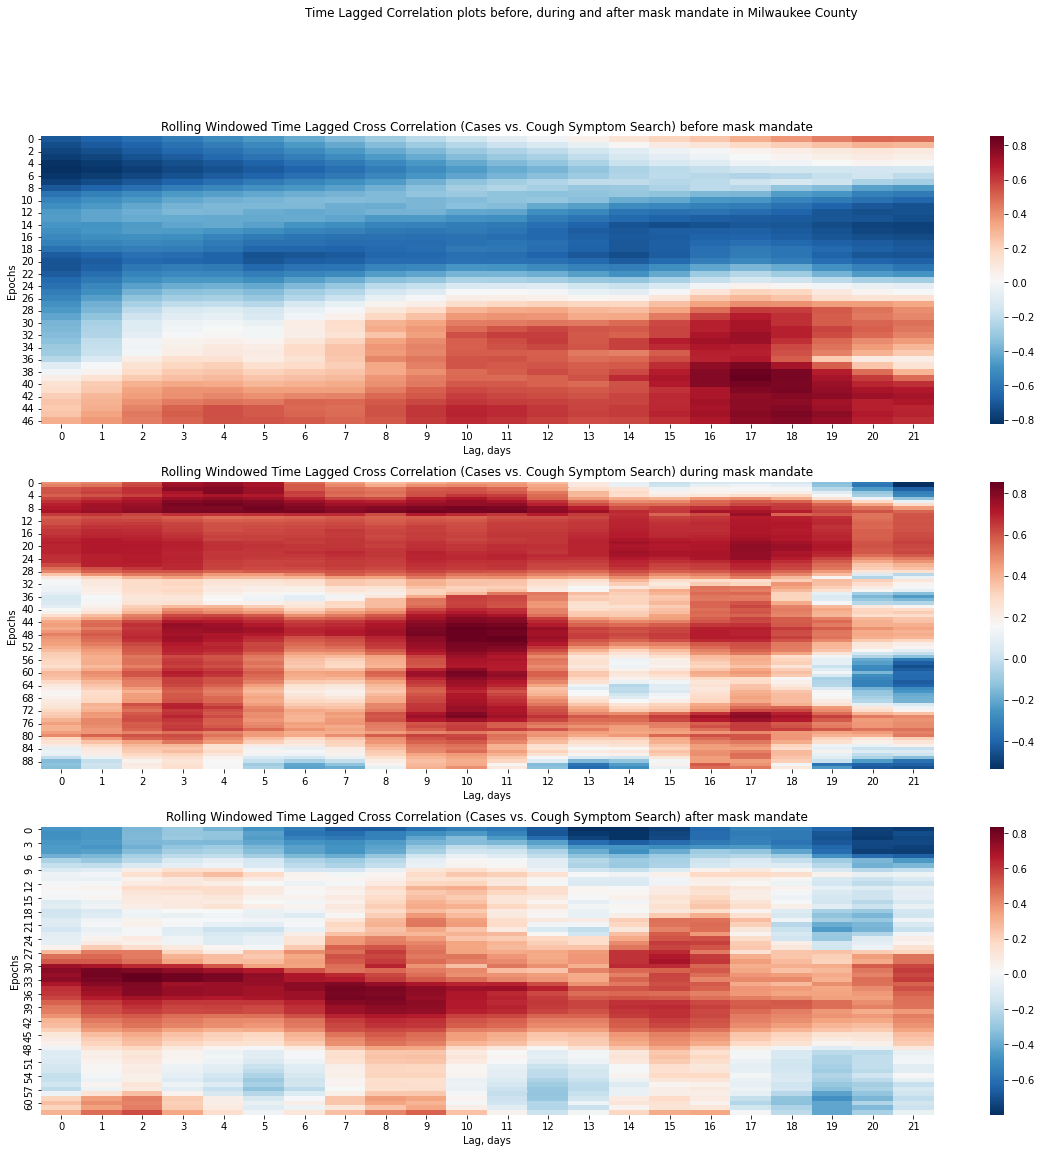

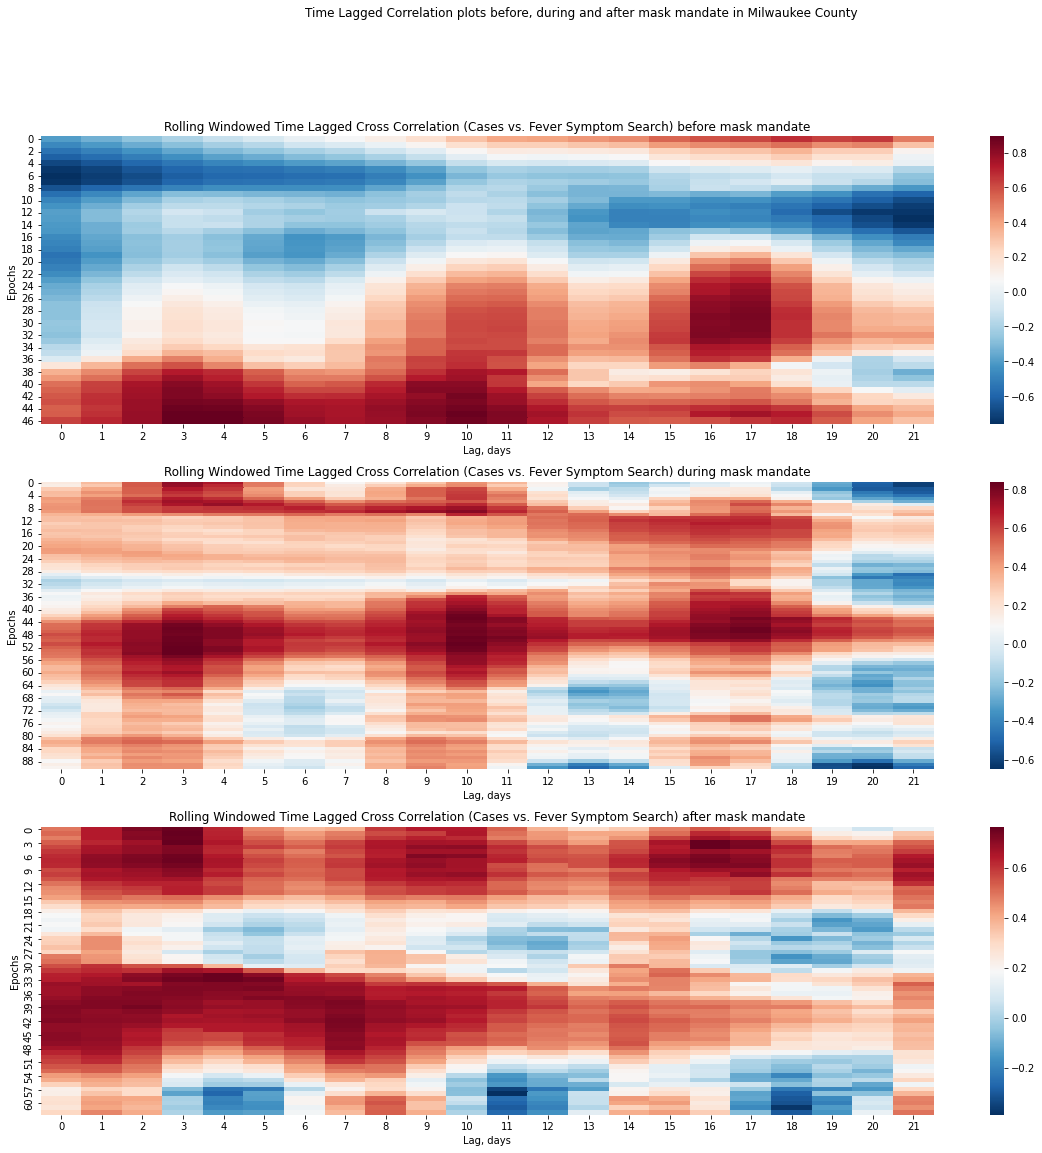

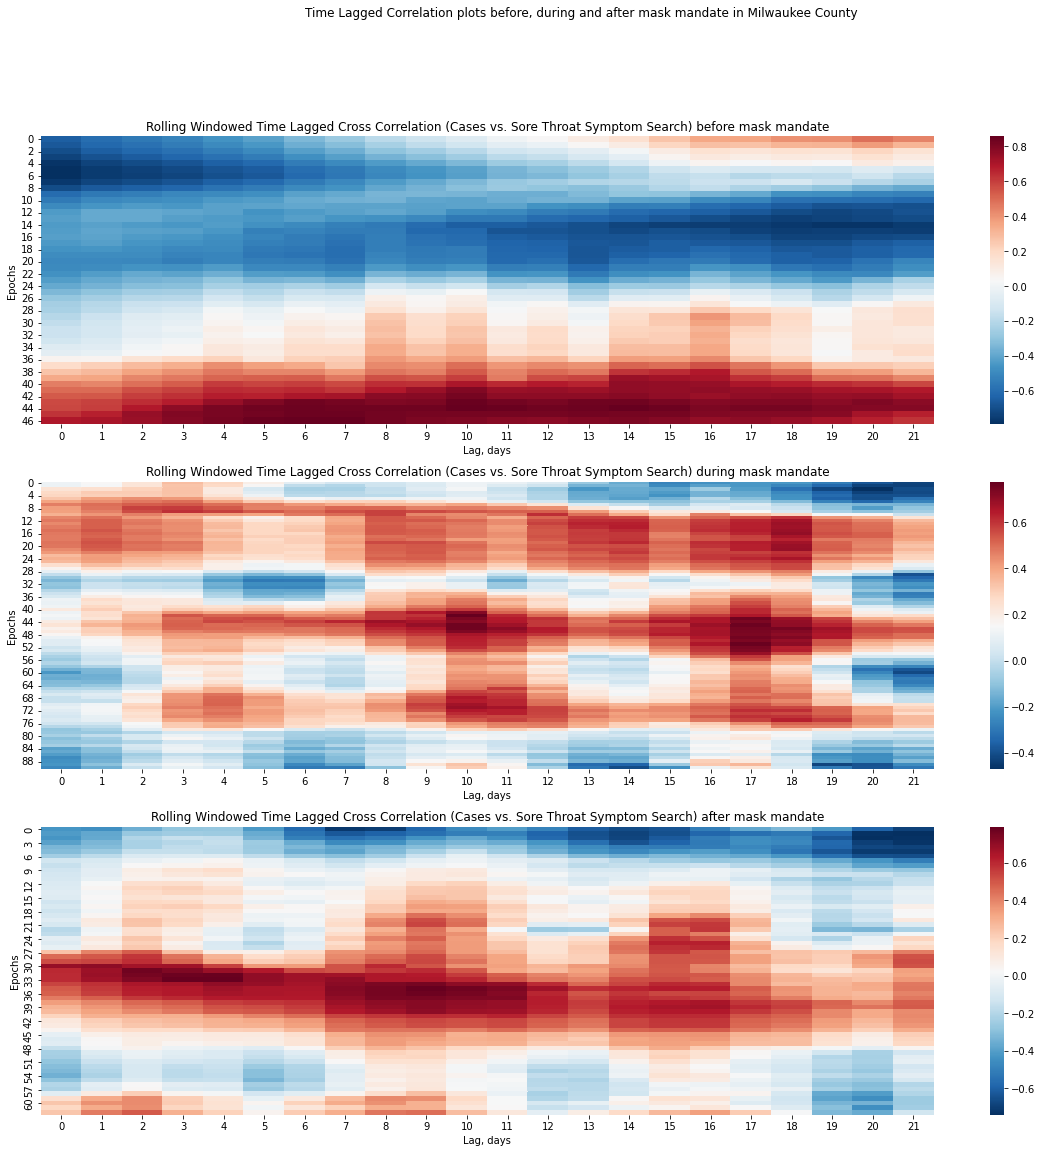

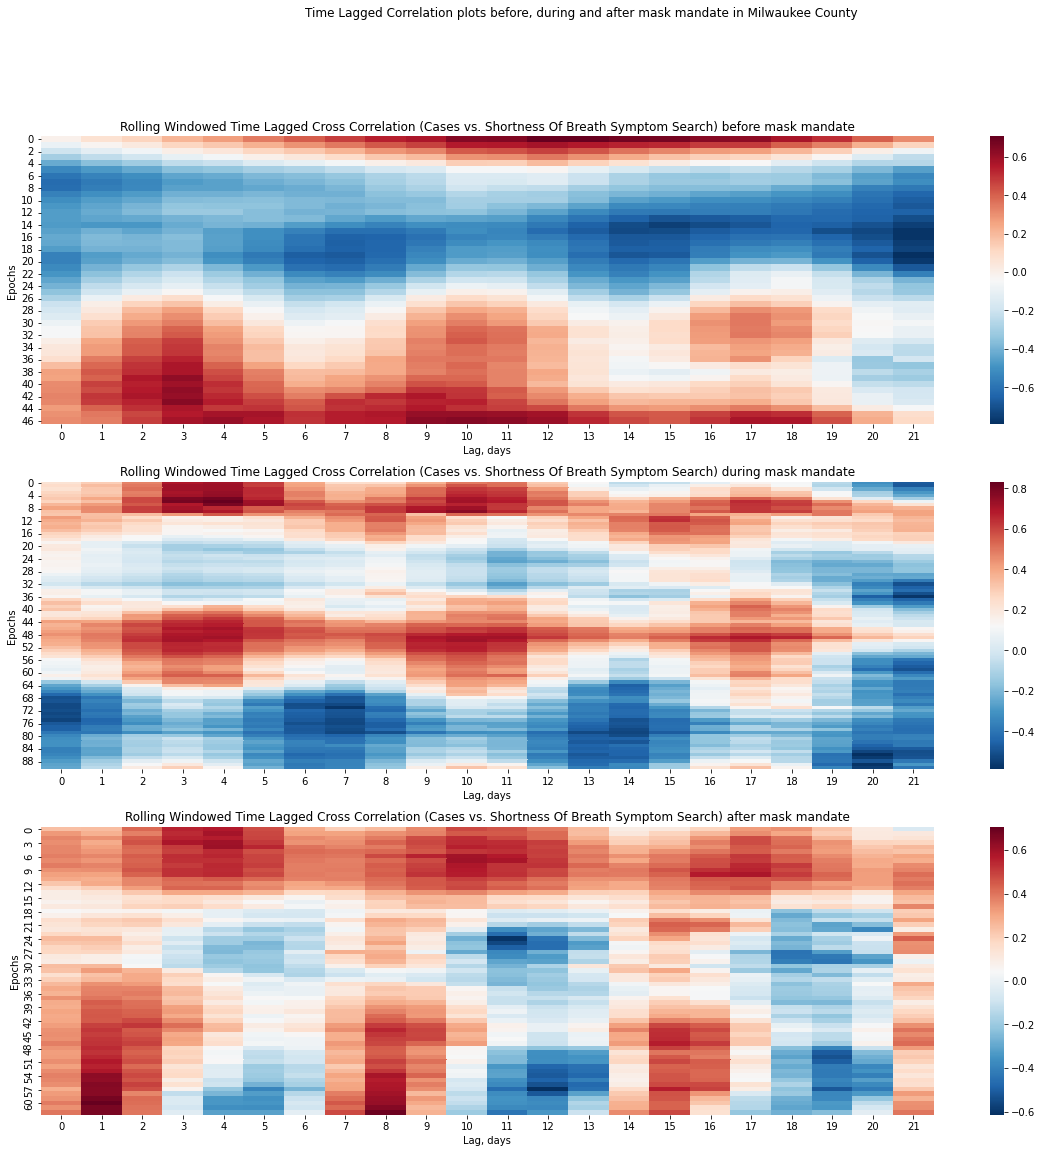

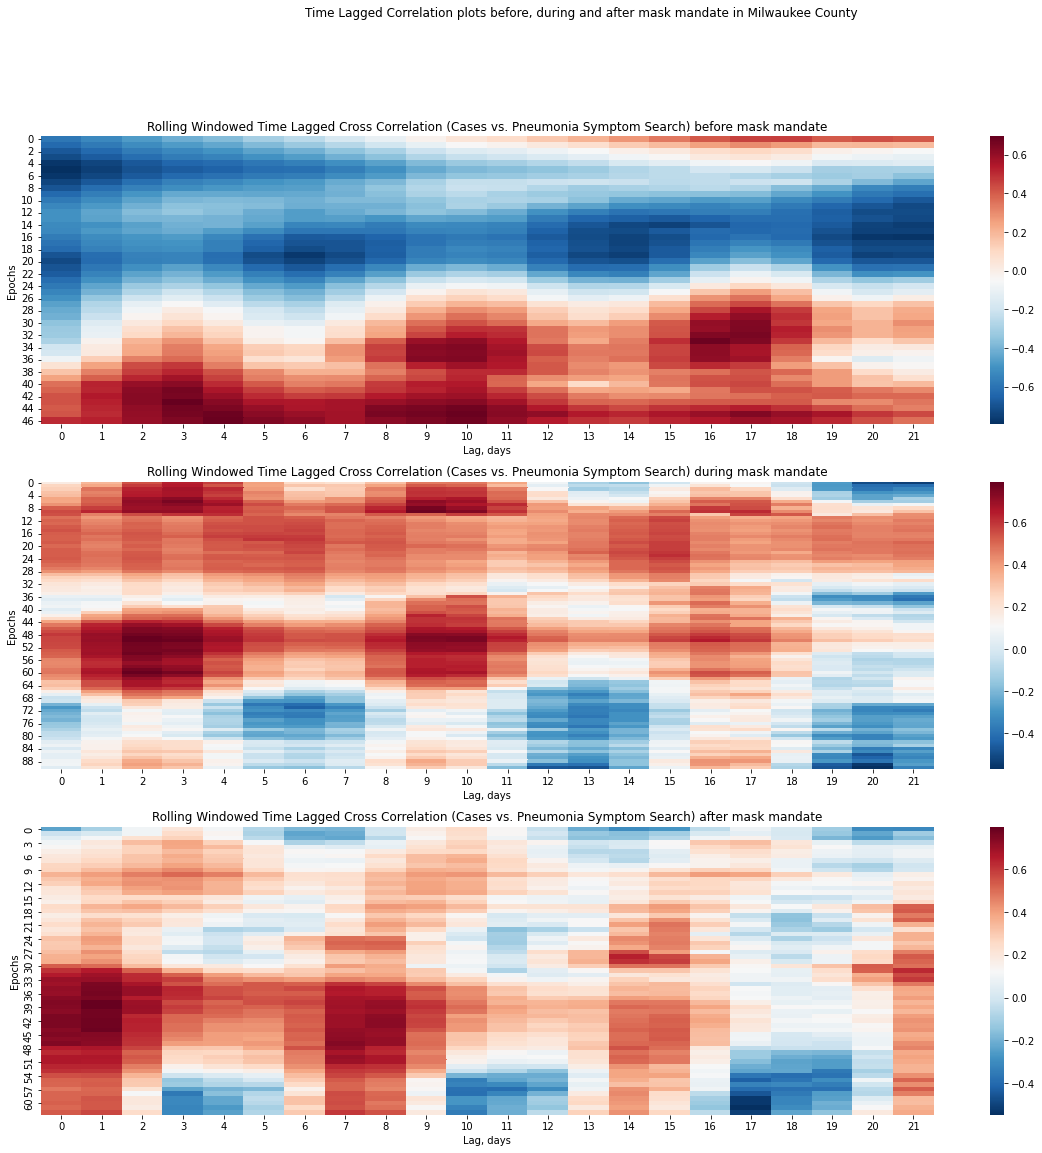

In [31]:
for i in top_symptoms:
  rss1, rss2, rss3 = window_corr(df_wave1, i),window_corr(df_wave2, i), window_corr(df_wave3, i)
  plot_corr(rss1, rss2, rss3, i)